In [55]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import markers
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots


<h1>Load the data</h1>

In [20]:
columns = ['fundamental', 'technic', 'cycle']
rows = ['drops_20', 'drops_10', 'same', 'increses_10']
values = np.array(
    [[0.1, 0.1, 0.15], [0.2, 0.2, 0.25], [0.3, 0.3, 0.35], [0.4, 0.4, 0.25]]
)
criterion_weights = pd.Series(data=np.array([1/3,1/3,1/3]), index=columns)
data = pd.DataFrame(data=values, index=rows, columns=columns)
data

,fundamental,technic,cycle
drops_20,0.1,0.1,0.15
drops_10,0.2,0.2,0.25
same,0.3,0.3,0.35
increses_10,0.4,0.4,0.25


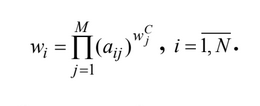

<h1>Graphical methods</h1>

In [44]:
def weights_multiplicative(data, weights):
    weights = np.array([np.prod(data.iloc[i]**criterion_weights) for i in range(data.shape[0])])
    return weights


In [46]:
global_weights = weights_multiplicative(data, criterion_weights)
global_weights

array([0.11447142, 0.21544347, 0.31581798, 0.34199519])

In [73]:
def vykonannya(data, weights, global_wieghts):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Bar(x=data.columns, y=weights, name="Criteria"), secondary_y = False)
    for i, row in enumerate(rows):
        fig.add_trace(go.Scatter(x=data.columns.tolist()+["Ziel", "global"], y=data.T[row].tolist()+2*[global_weights[i]], mode='lines', name = row), secondary_y = True)
    fig.update_yaxes(title_text="<b>Criteria</b> weights", secondary_y=False, range=[0,1])
    fig.update_yaxes(title_text="<b>Alternatives</b> weights", secondary_y=True)
    fig.show()

In [75]:
vykonannya(data, criterion_weights, global_weights)

In [3]:
def get_diapasons(weights, global_weights, name, closest):
    closest_ = closest.copy()
    weight = weights[name]
    
    closest_['global_left'] = closest_['first'].apply(lambda x: global_weights[x]) 
    closest_['global_right'] = closest_['second'].apply(lambda x: global_weights[x]) 
    
    closest_column = closest_.groupby(by=['first']).apply(lambda x: pd.concat([x] \
                * len(closest_['first'].unique()))).reset_index(drop=True).drop(columns\
                                                                =['second'])[['first', 'x', 'global_left']]
    closest_columns = closest_column.reset_index(drop=True)

    truncated = pd.concat([closest_[['first', 'x', 'global_left']]] * 
                          len(closest_['first'].unique())).reset_index(drop=True)
    
    closest_ = pd.concat((truncated, closest_column[['first', 'x', 'global_left']]), axis=1)
    closest_.columns = ['first', 'x', 'global_left', 'second', 'y', 'global_right']
    closest_ = closest_[['first', 'second', 'x', 'y', 'global_left', 'global_right']]
    closest_ = closest_[closest_['x'] != closest_['y']]

    deltas_threshold = (closest_['global_left'] - closest_['global_right']) / \
    (closest_['x'] - closest_['y']) * 1. / weight
    deltas_threshold = pd.merge(deltas_threshold.to_frame(), closest_[['first', 'second']], 
                                left_index=True, right_index=True)
    
    return deltas_threshold
    #w_star = 

def gradient_method(data, weights, global_weights):
    
    criterion_names = data.columns
    size = int(len(criterion_names) // 2) + 1
    fig, axes = plt.subplots(size, size, figsize=(12, 8))
    
    for i, criterion_name in enumerate(criterion_names):
    
        weights_left = weights.copy()
        weights_right = weights.copy()

        weights_left[criterion_name] = 0
        weights_left /= weights_left.sum()

        weights_right[~weights.index.isin({criterion_name})] = 0
        weights_right /= weights_right.sum()

        weights_alternative_left = weights_distributive(data, weights_left)
        weights_alternative_right = weights_distributive(data, weights_right)
        weights_to_plot = pd.concat((weights_alternative_left, weights_alternative_right), axis=1)

        intersections = [np.linalg.solve(np.array([[(first[2] - first[1]), -1], [(second[2] - second[1]), -1]])
                                                   , -np.array([first[1], second[1]])) \
        for first in weights_to_plot.itertuples() for second in weights_to_plot.itertuples() if first != second]
        
        intersections_all = pd.DataFrame.from_records(((weights_to_plot.index[int(i // 4)], 
                                    weights_to_plot.index[i % 4], intersections[i][0], intersections[i][1]) \
                                                       for i in range(len(intersections))))
        intersections_all = intersections_all.set_index(intersections_all[0], drop=True)
        intersections_all = pd.DataFrame(intersections_all.values)
        #intersections_all = intersections_all.drop(columns=[0])
        intersections_all.columns = ['first', 'second', 'x', 'y']
        weights_to_plot['intersection'] = np.array([ (line[2] - line[1]) * weights[criterion_name] + line[1] \
                                                    for line in weights_to_plot.itertuples()])
        optimal_alternative = weights_to_plot['intersection'].index[weights_to_plot['intersection'].argmax()]

        dist = abs(intersections_all['x'] - weights[criterion_name])
        arg_point = np.argmin(dist)
        
        #print(intersections_all[intersections_all['first'] == optimal_alternative])
        dist_optimals = abs(intersections_all[intersections_all['first'] == optimal_alternative]['x'] 
                                                                            - weights[criterion_name])
        arg_opt = dist_optimals[dist_optimals == dist_optimals.min()].index[0]
        
        val_1 = dist.min() / weights[criterion_name]
        val_2 = dist_optimals.min() / weights[criterion_name]
        
        print("-------------------------")
        print(f"Ступінь чутливості попарного ранжування для {criterion_name}: {val_1}")
        print(f"Ступінь чутливості оптимального ранжування для {criterion_name}: {val_2}")
       
        closest = intersections_all.groupby(by=['first'])
        groups = []
        for group in closest:
        
            points = group[1][group[1]['first'] == group[0]][['second', 'x']]
            points['first'] = group[0]
            points['x'] -= weights[criterion_name]
            to_append = points[['first', 'second', 'x']][abs(points['x']) == abs(points['x']).min()].iloc[0] 
            to_append['x'] += weights[criterion_name]
            groups.append(to_append)
        
        closest = pd.concat(groups, axis=1).T
    
        deltas_threshold = get_diapasons(weights, global_weights, criterion_name, closest)
    
        ax = axes[int(i // 2), i % 2]
        ax.plot(weights_to_plot.values[:, :-1].T, linestyle='dashed')
        ax.scatter(intersections_all['x'], intersections_all['y'], color='red', s=10)
        ax.scatter(intersections_all.iloc[arg_point, 2], intersections_all.iloc[arg_point, 3], color='black', s=100)
        ax.scatter(intersections_all.iloc[arg_opt, 2], intersections_all.iloc[arg_opt, 3], color='green', s=100)
        ax.vlines(weights[criterion_name], 0, 0.4, colors='red')
        ax.legend(data.index, loc=4)
        fig.suptitle("Gradient method")
        ax.set_xlabel(criterion_name)
        ax.set_xlim(0, 1)
        
        print(deltas_threshold)
    

IndexError: index 3 is out of bounds for axis 0 with size 3

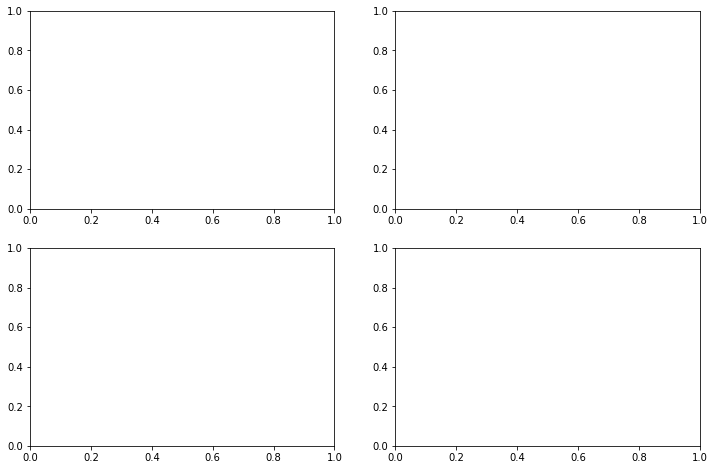

In [4]:
global_weights = weights_distributive(data, criterion_weights)
gradient_method(data, criterion_weights, global_weights)